In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import seaborn as sns
import xarray as xr
from collections import OrderedDict

In [2]:
tf.__version__

'2.16.1'

In [3]:
DATADIR = '../Data/'
PREDDIR = '../Predictions/'

In [4]:
ds = xr.open_mfdataset(f'{DATADIR}geopotential_500/*.nc', combine='by_coords', engine='netcdf4')
print(ds)
ds = ds.drop_vars('level')
print(ds)
ds_sliced = ds.sel(time=slice('2016', '2017'))
print(ds_sliced)
z500_valid = ds_sliced


<xarray.Dataset> Size: 3GB
Dimensions:  (lon: 64, lat: 32, time: 350640)
Coordinates:
    level    int32 4B 500
  * lon      (lon) float64 512B 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * lat      (lat) float64 256B -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 3MB 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 3GB dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-10 20:33:23 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...
<xarray.Dataset> Size: 3GB
Dimensions:  (lon: 64, lat: 32, time: 350640)
Coordinates:
  * lon      (lon) float64 512B 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * lat      (lat) float64 256B -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 3MB 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 3GB dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes

In [5]:
ds = xr.open_mfdataset(f'{DATADIR}temperature_850/*.nc', combine='by_coords', engine='netcdf4')
print(ds)
ds = ds.drop_vars('level')
print(ds)
ds_sliced = ds.sel(time=slice('2016', '2017'))
print(ds_sliced)
t850_valid = ds_sliced

<xarray.Dataset> Size: 3GB
Dimensions:  (lon: 64, lat: 32, time: 350640)
Coordinates:
  * lon      (lon) float64 512B 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * lat      (lat) float64 256B -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
    level    int32 4B 850
  * time     (time) datetime64[ns] 3MB 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    t        (time, lat, lon) float32 3GB dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-21 05:02:47 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...
<xarray.Dataset> Size: 3GB
Dimensions:  (lon: 64, lat: 32, time: 350640)
Coordinates:
  * lon      (lon) float64 512B 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * lat      (lat) float64 256B -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 3MB 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    t        (time, lat, lon) float32 3GB dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes

In [6]:
valid = xr.merge([z500_valid, t850_valid],compat='override' )

In [7]:
z = xr.open_mfdataset(f'{DATADIR}geopotential_500/*.nc', combine='by_coords')
t = xr.open_mfdataset(f'{DATADIR}temperature_850/*.nc', combine='by_coords').drop_vars('level')

In [8]:
datasets = [z, t]
ds = xr.merge(datasets)

In [9]:
ds_train = ds.sel(time=slice('2010', '2015'))  
ds_test = ds.sel(time=slice('2016', '2016'))

In [10]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True, mean=None, std=None):
        
        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time
        
        data = []
        for var, levels in var_dict.items():
            if levels is None:
                try:
                    data.append(ds[var])
                except ValueError:
                    generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
                    data.append(ds[var].expand_dims({'level': generic_level}, 1))
            else:
                data.append(ds[var].sel(level=levels))

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
        self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        # Normalize
        self.data = (self.data - self.mean) / self.std
        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time

        self.on_epoch_end()

        if load: print('Loading data into RAM'); self.data.load()
        
    def __len__(self):
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.data.isel(time=idxs + self.lead_time).values
        return X, y

    def on_epoch_end(self):
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)

In [11]:
dic = OrderedDict({'z': None, 't': None})
bs=32
lead_time=6

In [12]:
dg_train = DataGenerator(
    ds_train, dic, lead_time, batch_size=bs, load=True)
dg_valid = DataGenerator(
    ds_train, dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM
Loading data into RAM


In [13]:
dg_train.mean, dg_train.std

(<xarray.DataArray 'z' (level: 2)> Size: 8B
 array([54155.523  ,   274.75015], dtype=float32)
 Coordinates:
   * level    (level) int32 8B 500 500,
 <xarray.DataArray 'z' (level: 2)> Size: 8B
 array([1111.15    ,    5.677331], dtype=float32)
 Coordinates:
   * level    (level) int32 8B 500 500)

In [14]:
dg_test = DataGenerator(ds_test, dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM


In [15]:
class PeriodicPadding2D(tf.keras.layers.Layer):
    def __init__(self, pad_width, **kwargs):
        super().__init__(**kwargs)
        self.pad_width = pad_width

    def call(self, inputs, **kwargs):
        if self.pad_width == 0:
            return inputs
        inputs_padded = tf.concat(
            [inputs[:, :, -self.pad_width:, :], inputs, inputs[:, :, :self.pad_width, :]], axis=2)
        # Zero padding in the lat direction
        inputs_padded = tf.pad(inputs_padded, [[0, 0], [self.pad_width, self.pad_width], [0, 0], [0, 0]])
        return inputs_padded

    def get_config(self):
        config = super().get_config()
        config.update({'pad_width': self.pad_width})
        return config


class PeriodicConv2D(tf.keras.layers.Layer):
    def __init__(self, filters,
                 kernel_size,
                 conv_kwargs={},
                 **kwargs, ):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.conv_kwargs = conv_kwargs
        if type(kernel_size) is not int:
            assert kernel_size[0] == kernel_size[1], 'PeriodicConv2D only works for square kernels'
            kernel_size = kernel_size[0]
        pad_width = (kernel_size - 1) // 2
        self.padding = PeriodicPadding2D(pad_width)
        self.conv = Conv2D(
            filters, kernel_size, padding='valid', **conv_kwargs
        )

    def call(self, inputs):
        return self.conv(self.padding(inputs))

    def get_config(self):
        config = super().get_config()
        config.update({'filters': self.filters, 'kernel_size': self.kernel_size, 'conv_kwargs': self.conv_kwargs})
        return config

In [16]:
def build_cnn(filters, kernels, input_shape, dr=0):
    """Fully convolutional network"""
    x = input = Input(shape=input_shape)
    for f, k in zip(filters[:-1], kernels[:-1]):
        x = PeriodicConv2D(f, k)(x)
        x = LeakyReLU()(x)
        if dr > 0: x = Dropout(dr)(x)
    output = PeriodicConv2D(filters[-1], kernels[-1])(x)
    return keras.models.Model(input, output)

In [17]:
cnn = build_cnn([64, 64, 64, 64, 2], [5, 5, 5, 5, 5], (32, 64, 2))

In [18]:
cnn.compile(keras.optimizers.Adam(1e-4), 'mse')

In [19]:
cnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 64, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ periodic_conv2d                 │ (None, 32, 64, 64)     │         3,264 │
│ (PeriodicConv2D)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ periodic_conv2d_1               │ (None, 32, 64, 64)     │       102,464 │
│ (PeriodicConv2D)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ periodic_conv2d_2               │ (None, 32, 64, 64)     │       102,464 │
│ (PeriodicConv2D)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ periodic_conv2d_3               │ (None, 32, 64, 64)     │       102,464 │
│ (PeriodicConv2D)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ periodic_conv2d_4               │ (None, 32, 64, 2)      │         3,202 │
│ (PeriodicConv2D)                │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 313,858 (1.20 MB)

 Trainable params: 313,858 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Since we didn't load the full data this is only for demonstration.
cnn.fit(dg_train, epochs=5, validation_data=dg_valid, 
          callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        min_delta=0,
                        patience=3,
                        verbose=1, 
                        mode='auto'
                    )]
         )

Epoch 1/5


C:\Users\sraj2\PycharmProjects\ML_Project_SEM6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1644/1644 ━━━━━━━━━━━━━━━━━━━━ 371s 225ms/step - loss: 0.3384 - val_loss: 0.0473
Epoch 2/5
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 349s 212ms/step - loss: 0.0457 - val_loss: 0.0421
Epoch 3/5
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 351s 214ms/step - loss: 0.0418 - val_loss: 0.0401
Epoch 4/5
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 352s 214ms/step - loss: 0.0394 - val_loss: 0.0379
Epoch 5/5
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 354s 215ms/step - loss: 0.0378 - val_loss: 0.0375


In [21]:
def create_predictions(model, dg):
    preds = model.predict(dg)
    # Unnormalize
    preds = preds * dg.std.values + dg.mean.values
    fcs = []
    lev_idx = 0
    for var, levels in dg.var_dict.items():
        if levels is None:
            fcs.append(xr.DataArray(
                preds[:, :, :, lev_idx],
                dims=['time', 'lat', 'lon'],
                coords={'time': dg.valid_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon},
                name=var
            ))
            lev_idx += 1
        else:
            nlevs = len(levels)
            fcs.append(xr.DataArray(
                preds[:, :, :, lev_idx:lev_idx+nlevs],
                dims=['time', 'lat', 'lon', 'level'],
                coords={'time': dg.valid_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon, 'level': levels},
                name=var
            ))
            lev_idx += nlevs
    return xr.merge(fcs)

In [22]:
fc = create_predictions(cnn, dg_test)

275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step


In [23]:
def compute_weighted_rmse(da_fc, da_true, mean_dims=xr.ALL_DIMS):
    error = da_fc - da_true
    weights_lat = np.cos(np.deg2rad(error.lat))
    weights_lat /= weights_lat.mean()
    rmse = np.sqrt(((error) ** 2 * weights_lat).mean(mean_dims))
    return rmse

In [24]:
compute_weighted_rmse(fc, valid).compute()

<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    z        float64 8B 145.3
    t        float64 8B 1.309

In [25]:
def create_iterative_predictions(model, dg, max_lead_time=5*24):
    state = dg.data[:dg.n_samples]
    preds = []
    for _ in range(max_lead_time // dg.lead_time):
        state = model.predict(state)
        p = state * dg.std.values + dg.mean.values
        preds.append(p)
    preds = np.array(preds)
    
    lead_time = np.arange(dg.lead_time, max_lead_time + dg.lead_time, dg.lead_time)
    das = []; lev_idx = 0
    for var, levels in dg.var_dict.items():
        if levels is None:
            das.append(xr.DataArray(
                preds[:, :, :, :, lev_idx],
                dims=['lead_time', 'time', 'lat', 'lon'],
                coords={'lead_time': lead_time, 'time': dg.init_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon},
                name=var
            ))
            lev_idx += 1
        else:
            nlevs = len(levels)
            das.append(xr.DataArray(
                preds[:, :, :, :, lev_idx:lev_idx+nlevs],
                dims=['lead_time', 'time', 'lat', 'lon', 'level'],
                coords={'lead_time': lead_time, 'time': dg.init_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon, 'level': levels},
                name=var
            ))
            lev_idx += nlevs
    return xr.merge(das)

In [26]:
fc_iter = create_iterative_predictions(cnn, dg_test)

275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step


In [29]:
df = fc_iter.to_dataframe()
df.to_csv('../Prediction/output.csv')

In [27]:
fc_iter.to_netcdf('../Predictions/fc_iter.nc')

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\sraj2\\PycharmProjects\\ML_Project_SEM6\\Predictions\\fc_iter.nc'

In [35]:
def romse(fc, da_true, mean_dims=xr.ALL_DIMS):
    """Compute Root Mean Squared Error (RMSE) between forecast (fc) and truth (da_true)."""
    return ((fc - da_true)**2).mean(dim=mean_dims)**0.5


In [36]:
def evaluate_iterative_forecast(da_fc, da_true,func, mean_dims=xr.ALL_DIMS):
    rmses = []
    for f in da_fc.lead_time:
        fc = da_fc.sel(lead_time=f)
        fc['time'] = fc.time + np.timedelta64(int(f), 'h')
        rmses.append(func(fc, da_true, mean_dims))
    return xr.concat(rmses, 'lead_time')

In [37]:
rmse = evaluate_iterative_forecast(fc_iter, valid,romse)

In [38]:
rmse.load()

<xarray.Dataset> Size: 240B
Dimensions:    (lead_time: 20)
Coordinates:
  * lead_time  (lead_time) int32 80B 6 12 18 24 30 36 ... 90 96 102 108 114 120
Data variables:
    z          (lead_time) float32 80B 156.8 253.0 343.4 ... 1.184e+03 1.215e+03
    t          (lead_time) float32 80B 1.348 1.906 2.246 ... 5.764 5.916 6.058

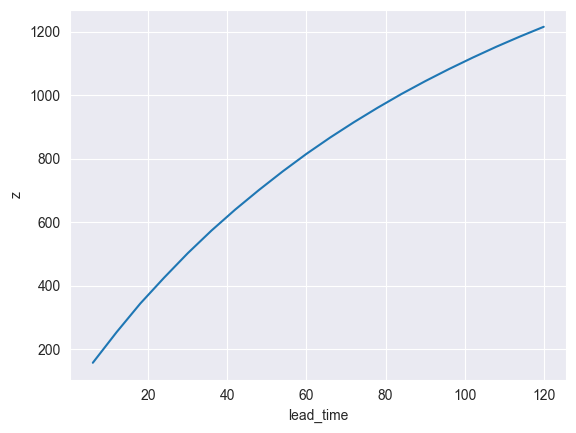

In [39]:
rmse.z.plot()

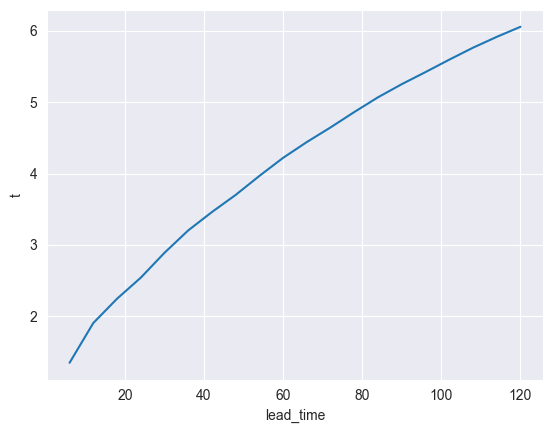

In [40]:
rmse.t.plot()